### Feature Engineering and Sentiment Analysis

In [1]:
import sys
print(sys.version)
print(spark.version)

import os
import subprocess
from pyspark.sql.functions import *
from pyspark.sql.types import *

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]
3.1.3


In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [3]:
%pip install nltk -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.3/772.3 kB 50.5 MB/s eta 0:00:00
  Attempting uninstall: regex
    Found existing installation: regex 2021.4.4
    Uninstalling regex-2021.4.4:
      Successfully uninstalled regex-2021.4.4
  Attempting uninstall: nltk
    Found existing installation: nltk 3.6.4
    Uninstalling nltk-3.6.4:
      Successfully uninstalled nltk-3.6.4
Note: you may need to restart the kernel to use updated packages.


In [4]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [6]:
sc = spark.sparkContext
print('Original spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))

Original spark.driver.maxResultSize: 1920m


### Read the dataset

In [7]:
path = 'gs://msca-bdp-students-bucket/shared_data/qsliu/elearning_df'

elearning_df = spark.read.parquet(path)

In [8]:
elearning_df.limit(5)

23/02/26 23:46:31 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


created_at,unique_id,favorite_count,tweet_location_type,tweet_location,tweet_country,quote_count,reply_count,retweet_count,retweeted,retweeted_from,source,tweet_text,timestamp_ms,user_id,user_name,user_screen_name,user_description,user_location,user_verified,followers_count,year,month,time,day_of_week,month_year,user_affiliated_organization,user_location_specific,tweet_location_specific
Thu Dec 01 09:54:...,1598254076130910208,0,null,null,null,0,0,896,RT,VVL_Official,"<a href=""http://t...",a great conceptua...,1669888440531,1598254076130910208,Lakshmipathi G,Lakshmi07895026,Lakshmipathi,null,false,0,2022,Dec,09,Thu,Dec 2022,other,null,null
Thu Dec 01 09:54:...,1598254097458941953,0,null,null,null,0,0,171,RT,Fact,"<a href=""http://t...",your entire life ...,1669888445616,1598254097458941953,Vic_jamal🇰🇪,vic_jamal,Game changer 🤓 G...,"Nairobi, Kenya",false,1244,2022,Dec,09,Thu,Dec 2022,other,Nairobi,null
Thu Dec 01 09:54:...,1598254105306497024,0,null,null,null,0,0,3,RT,AM05947500,"<a href=""http://t...",#ags #armygoodwil...,1669888447487,1598254105306497024,Roshan Toppo,RoshanT54331044,null,null,false,1,2022,Dec,09,Thu,Dec 2022,other,null,null
Thu Dec 01 09:54:...,1598254127007539201,0,null,null,null,0,0,null,,null,"<a href=""http://w...","all means, genera...",1669888452661,1598254127007539201,able ◥•ﻜٕوِبون• ‏...,luis17tqamo,the window of the...,null,false,32,2022,Dec,09,Thu,Dec 2022,other,null,null
Thu Dec 01 09:54:...,1598254127083302912,0,null,null,null,0,0,null,,null,"<a href=""http://t...",jai hind sir #ag...,1669888452679,1598254127083302912,Vipul Patole,Vipulpa2812,null,null,false,0,2022,Dec,09,Thu,Dec 2022,other,null,null


In [9]:
elearning_df.count()

5980433

In [9]:
all_df = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/qsliu/tweet_df')

In [12]:
all_df.printSchema()

root
 |-- created_at: string (nullable = true)
 |-- unique_id: long (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- tweet_location_type: string (nullable = true)
 |-- tweet_location: string (nullable = true)
 |-- tweet_country: string (nullable = true)
 |-- quote_count: long (nullable = true)
 |-- reply_count: long (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- retweeted: string (nullable = true)
 |-- retweeted_from: string (nullable = true)
 |-- source: string (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- timestamp_ms: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_screen_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_location: string (nullable = true)
 |-- user_verified: boolean (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- ti

In [13]:
all_df.count()

99178473

In [8]:
subset_df = elearning_df.select("user_screen_name", "user_affiliated_organization", "retweet_count", "followers_count", "unique_id")

# more followers = more retweets?
#subset_df = subset_df.withColumn("retweet_over_followers", when(col("followers_count") > 0, (col("retweet_count")/col("followers_count"))).otherwise(None))
grouped_df = subset_df.groupBy("user_screen_name") \
                      .agg((sum("retweet_count")/count("unique_id")).alias("retweets_over_tweets"),
                           count("unique_id").alias("number_of_tweets"),
                           sum("retweet_count").alias("total_retweets"),
                           avg("followers_count").alias("followers"),
                           ((avg("followers_count")/sum("retweet_count"))*100).alias("retweet_over_followers"),
                           first("user_affiliated_organization").alias("user_affiliated_organization"))

In [12]:
#subset_df.limit(5)

In [10]:
high_retweets = grouped_df.orderBy("retweets_over_tweets", ascending=False).toPandas()
high_retweets.head(10)

,user_screen_name,retweets_over_tweets,number_of_tweets,total_retweets,followers,retweet_over_followers,user_affiliated_organization
0,boraxmeatballs,233417.0,1,233417.0,16.0,0.006855,other
1,ughhnika,232379.0,1,232379.0,965.0,0.415270,other
2,clearlycrystalz,231784.0,1,231784.0,207.0,0.089307,other
3,Lunaablackk96,231747.0,1,231747.0,0.0,0.000000,other
4,rachalelliott__,230352.0,1,230352.0,121.0,0.052528,other
5,cameronroyal_,227369.0,1,227369.0,172.0,0.075648,other
6,Ayl_spn,208521.0,1,208521.0,1667.0,0.799440,other
7,NC4LIFE75,148734.0,1,148734.0,357.0,0.240026,other
8,K89308477,148708.0,1,148708.0,19.0,0.012777,other
9,EBODADDY,148706.0,1,148706.0,295.0,0.198378,other


In [11]:
high_tweets = grouped_df.orderBy("number_of_tweets", ascending=False).toPandas()
high_tweets.head(10)

,user_screen_name,retweets_over_tweets,number_of_tweets,total_retweets,followers,retweet_over_followers,user_affiliated_organization
0,NJSchoolJobs,0.005622,10495,59.0,4122.913768,6987.989438,other
1,education_24x7,1.678101,8571,14383.0,7844.577646,54.540622,other
2,educationbnb,1.040472,4151,4319.0,1019.590460,23.607096,other
3,jc_james_clark,3.789552,4039,15306.0,3719.031691,24.297868,k_12
4,poet_this,NaN,3051,NaN,53783.065880,NaN,other
5,poskeos,NaN,2869,NaN,1.476473,NaN,other
6,imbatman2018,0.005549,2523,14.0,1560.426873,11145.906234,k_12
7,dealsoftakis,NaN,2502,NaN,88.034772,NaN,k_12
8,Shopyazanophu33,NaN,2425,NaN,19.927010,NaN,other
9,Rdene915,0.190371,2264,431.0,33032.298587,7664.106401,other


[Text(0.5, 1.0, 'Average Retweets Over the Number of Followers (Top 10)')]

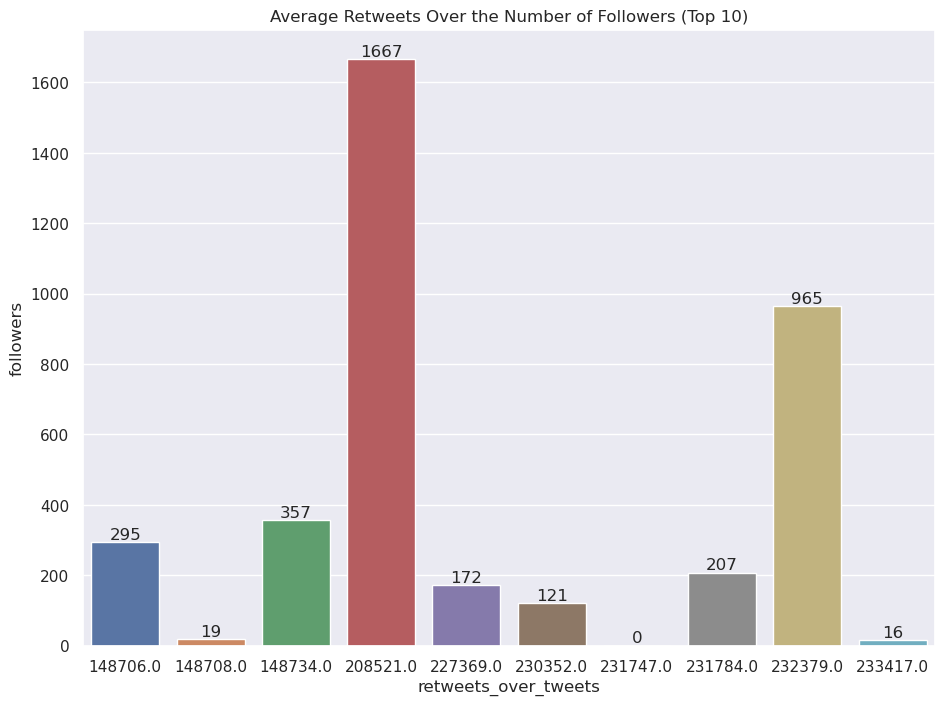

In [14]:
top_10 = high_retweets.head(10)
last_10 = high_retweets.dropna().round(5).tail(10)
top_bottom = pd.concat([top_10, last_10])

sns.set(rc={'figure.figsize':(11,8)})
ax = sns.barplot(x = top_10['retweets_over_tweets'], y = top_10['followers'])
for i in ax.containers:
    ax.bar_label(i,)
    
ax.set(title="Average Retweets Over the Number of Followers (Top 10)")

[Text(0.5, 1.0, 'Average Retweets Over the Number of Followers (Last 10)')]

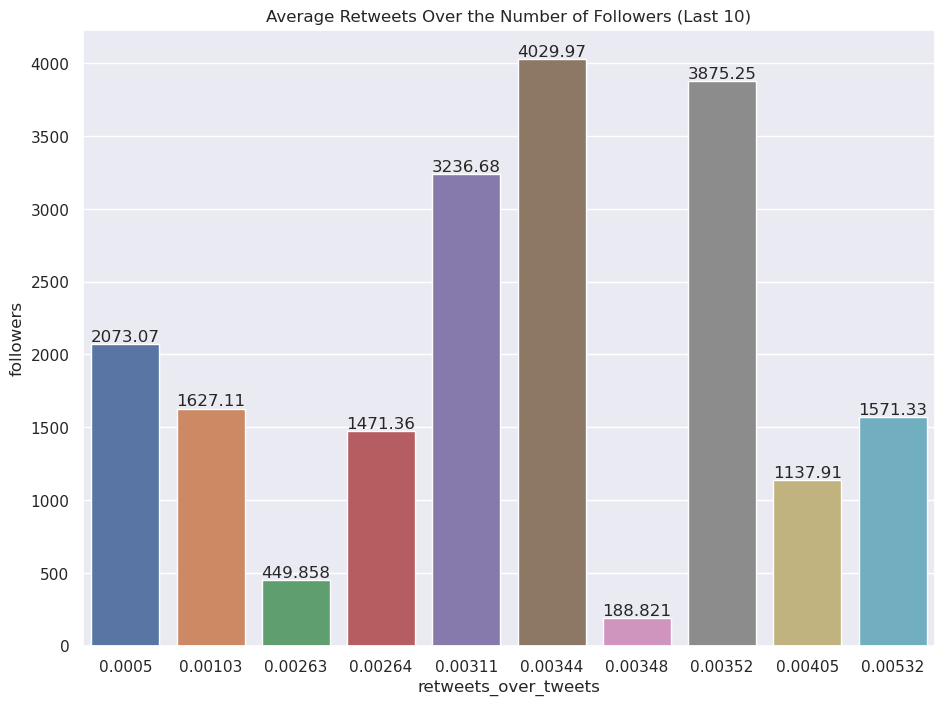

In [15]:
sns.set(rc={'figure.figsize':(11,8)})
ax = sns.barplot(x = last_10['retweets_over_tweets'], y = last_10['followers'])
for i in ax.containers:
    ax.bar_label(i,)
    
ax.set(title="Average Retweets Over the Number of Followers (Last 10)")

In [8]:
!pip install textblob

In [9]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
sample_df = elearning_df.sample(0.001).limit(5000)

In [11]:
sample_df.count()

5000

In [12]:
tweet_list = sample_df.select('tweet_text').rdd.flatMap(lambda x: x).collect()

In [13]:
sentiment_scores = [analyzer.polarity_scores(text) for text in tweet_list]

In [14]:
sentiment_compound_scores = [d['compound'] for d in sentiment_scores]

In [15]:
sample_df = sample_df.withColumn('id', monotonically_increasing_id())

tweet_sentiment = spark.createDataFrame([(i, x) for i, x in enumerate(sentiment_compound_scores)], ['id', 'sentiment_score'])

sample_df = sample_df.join(tweet_sentiment, on='id').drop('id')

In [16]:
sample_df.limit(5)

23/03/08 19:44:34 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


created_at,unique_id,favorite_count,tweet_location_type,tweet_location,tweet_country,quote_count,reply_count,retweet_count,retweeted,retweeted_from,source,tweet_text,timestamp_ms,user_id,user_name,user_screen_name,user_description,user_location,user_verified,followers_count,year,month,time,day_of_week,month_year,user_affiliated_organization,user_location_specific,tweet_location_specific,sentiment_score
Thu Sep 29 20:24:...,1575582256986394626,0,null,null,null,0,0,null,,null,"<a href=""http://t...",@simonharris_mbd ...,1664483057625,1575582256986394626,𓊈🆂🆃🅴🆅🅴🅽 🅲...,CellsReinvent,Reluctant optimist,"Manchester, England.",false,161,2022,Sep,20,Thu,Sep 2022,other,Manchester,null,-0.4588
Fri Nov 04 16:39:...,1588571528308064257,0,null,null,null,0,0,null,,null,"<a href=""http://t...",got an email from...,1667579941237,1588571528308064257,🐮CowtownGirl🐮sh...,CowtwnMama,“She is both hell...,"Calgary, Alberta,...",false,340,2022,Nov,16,Fri,Nov 2022,other,Calgary,null,0.4749
Wed Dec 28 18:38:...,1608170432783421446,0,null,null,null,0,0,null,,null,"<a href=""https://...",niger basic educa...,1672252684194,1608170432783421446,Peoples Gazette,GazetteNGR,"Truth, Courage or...","Abuja, FCT, Nigeria",true,352685,2022,Dec,18,Wed,Dec 2022,other,Abuja,null,-0.5245
Sun Jul 17 03:17:...,1548507227572432898,0,null,null,null,0,0,null,,MontyBoa99 Americ...,"<a href=""https://...",@rustyfairbanks @...,1658027867583,1548507227572432898,Buffalo Bills Fan...,CRose2u,❤️💙#GoBills 🏈❤️...,United States,false,15340,2022,Jul,03,Sun,Jul 2022,other,United States,null,0.0772
Wed Jan 04 17:01:...,1610682737005924352,0,null,null,null,0,0,77,RT,AfricaFactsZone,"<a href=""http://t...","hollywood star, m...",1672851664197,1610682737005924352,Weija Sherlock Ho...,_Wopre_dodo,||Environmental E...,"Accra, Ghana",false,6894,2023,Jan,17,Wed,Jan 2023,other,Accra,null,0.7845


In [17]:
from pyspark.sql.functions import corr

corr_value = sample_df.corr('sentiment_score', 'retweet_count')
print('Correlation:', corr_value)

Correlation: -0.014781916794711898


In [18]:
sentiment = sample_df.orderBy("retweet_count", ascending=False).toPandas()
sentiment.head(10)

,created_at,unique_id,favorite_count,tweet_location_type,tweet_location,tweet_country,quote_count,reply_count,retweet_count,retweeted,...,followers_count,year,month,time,day_of_week,month_year,user_affiliated_organization,user_location_specific,tweet_location_specific,sentiment_score
0,Fri Sep 02 04:37:15 +0000 2022,1565559456666365953,0,None,None,None,0,0,114832.0,RT,...,166,2022,Sep,04,Fri,Sep 2022,other,Error 404,None,0.4404
1,Sat Jun 18 21:48:05 +0000 2022,1538277396478103552,0,None,None,None,0,0,59822.0,RT,...,879,2022,Jun,21,Sat,Jun 2022,other,None,None,-0.9313
2,Fri Dec 23 07:57:29 +0000 2022,1606197287771705344,0,None,None,None,0,0,55019.0,RT,...,715,2022,Dec,07,Fri,Dec 2022,other,,None,-0.6615
3,Fri Dec 23 06:21:28 +0000 2022,1606173124533186560,0,None,None,None,0,0,54578.0,RT,...,73,2022,Dec,06,Fri,Dec 2022,other,None,None,0.8658
4,Fri Dec 23 04:26:20 +0000 2022,1606144147940843520,0,None,None,None,0,0,53979.0,RT,...,149,2022,Dec,04,Fri,Dec 2022,other,Porto,None,-0.6310
5,Thu Dec 22 21:51:42 +0000 2022,1606044835802058752,0,None,None,None,0,0,51514.0,RT,...,48,2022,Dec,21,Thu,Dec 2022,other,Alajuela,None,-0.7334
6,Thu Dec 22 20:17:40 +0000 2022,1606021171891146753,0,None,None,None,0,0,50642.0,RT,...,249,2022,Dec,20,Thu,Dec 2022,other,Nuevo León,None,0.6908
7,Sat Jun 18 02:33:28 +0000 2022,1537986826626969602,0,None,None,None,0,0,48230.0,RT,...,354,2022,Jun,02,Sat,Jun 2022,other,Dallas,None,0.5158
8,Sat Jun 18 01:10:20 +0000 2022,1537965905845448704,0,None,None,None,0,0,46374.0,RT,...,62,2022,Jun,01,Sat,Jun 2022,other,None,None,-0.6249
9,Sat Jun 18 01:05:20 +0000 2022,1537964648162414593,0,None,None,None,0,0,46272.0,RT,...,207,2022,Jun,01,Sat,Jun 2022,other,None,None,-0.8834


[Text(0.5, 1.0, 'Highest Retweets Tweets Over Sentiment Score of the Tweet (Top 20)')]

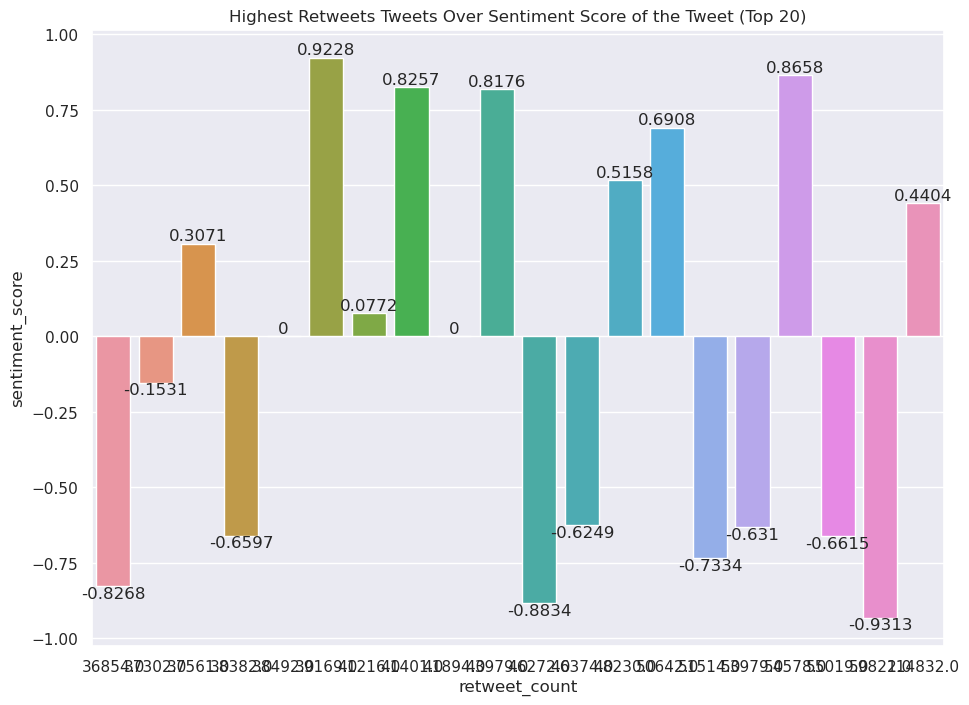

In [19]:
retweet_20 = sentiment.head(20)

sns.set(rc={'figure.figsize':(11,8)})
ax = sns.barplot(x = retweet_20['retweet_count'], y = retweet_20['sentiment_score'])
for i in ax.containers:
    ax.bar_label(i,)
    
ax.set(title="Highest Retweets Tweets Over Sentiment Score of the Tweet (Top 20)")

### More EDA

In [24]:
elearning_df.printSchema()

root
 |-- created_at: string (nullable = true)
 |-- unique_id: long (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- tweet_location_type: string (nullable = true)
 |-- tweet_location: string (nullable = true)
 |-- tweet_country: string (nullable = true)
 |-- quote_count: long (nullable = true)
 |-- reply_count: long (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- retweeted: string (nullable = true)
 |-- retweeted_from: string (nullable = true)
 |-- source: string (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- timestamp_ms: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_screen_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_location: string (nullable = true)
 |-- user_verified: boolean (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- ti

In [9]:
elearning_df.select('retweet_count').describe()

summary,retweet_count
count,4110459
mean,1447.645059104105
stddev,4843.686990367992
min,1
max,233417


In [13]:
elearning_df.select('retweet_count').filter(elearning_df.retweet_count >= 1000).describe()

summary,retweet_count
count,783028
mean,7081.397808252068
stddev,9152.52636359912
min,1000
max,233417


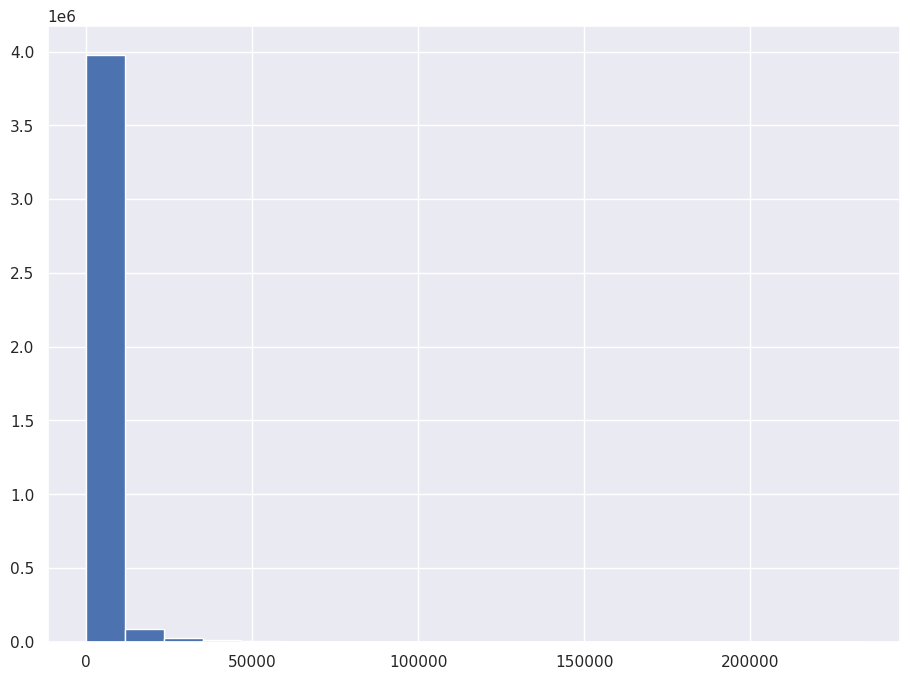

In [26]:
retweet = elearning_df.select('retweet_count').rdd.flatMap(lambda x: x).filter(lambda x: x is not None).collect()
plt.hist(retweet, bins=20)
plt.show()

In [11]:
elearning_df.select('followers_count').describe()

summary,followers_count
count,5980433
mean,8471.385427610341
stddev,238994.97678699158
min,0
max,83552404


In [31]:
elearning_df.filter(col("retweet_count") < 1000).select("unique_id").count()

3327431

In [32]:
3327431/5980433

0.5563863017945356

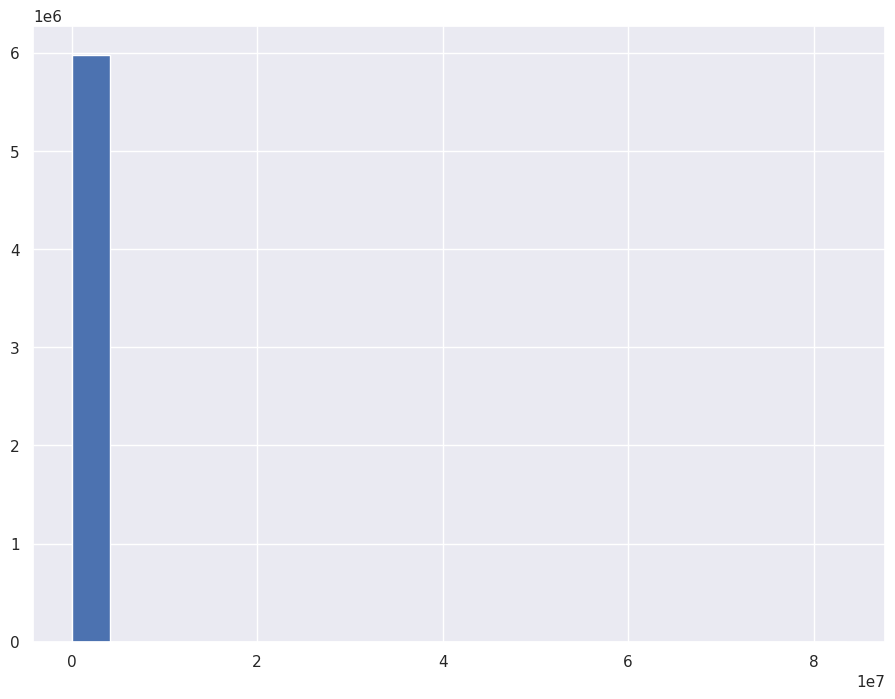

In [28]:
follower = elearning_df.select('followers_count').rdd.flatMap(lambda x: x).filter(lambda x: x is not None).collect()
plt.hist(follower, bins=20)
plt.show()

In [14]:
df = elearning_df

In [15]:
df = df.withColumn('num_words', size(split(df.tweet_text, ' ')))

In [16]:
df.select('num_words').describe()

summary,num_words
count,5980433
mean,34.81482962855699
stddev,10.758359811144048
min,1
max,177


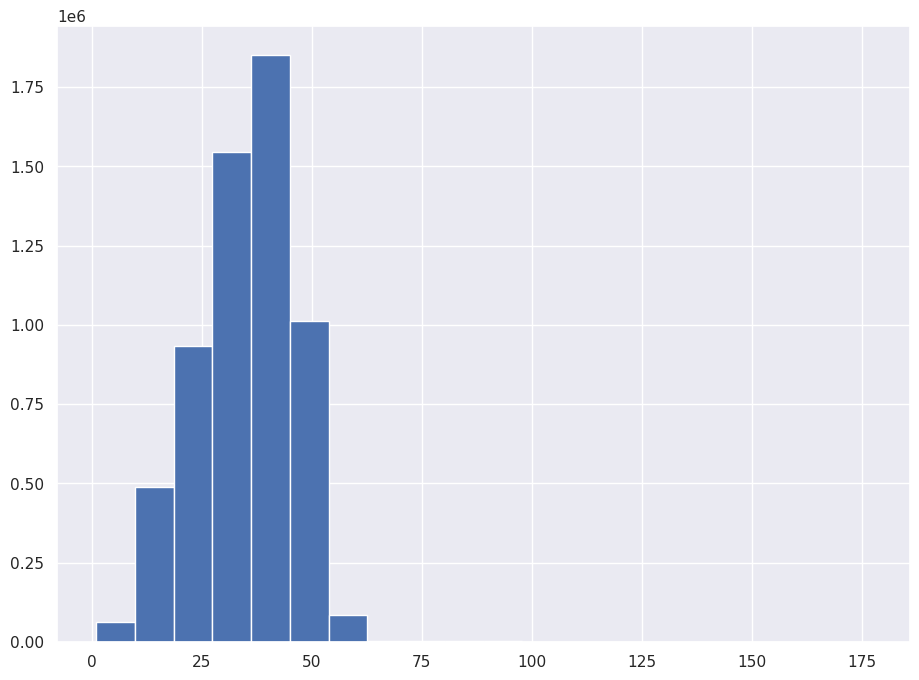

In [27]:
words_count = df.select('num_words').rdd.flatMap(lambda x: x).filter(lambda x: x is not None).collect()
plt.hist(words_count, bins=20)
plt.show()

In [8]:
elearning_df.filter(elearning_df.retweeted_from.isNull()).groupby('user_affiliated_organization').count().sort(desc(count('unique_id'))).toPandas()

,user_affiliated_organization,count
0,other,1128822
1,k_12,103927
2,news_related,60329
3,government,44037
4,higher_education,37129
5,non_profit,5640


In [13]:
elearning_df.filter(elearning_df.retweeted_from.isNull()).count()

1379884

In [15]:
elearning_df.select([count(col(c).isNull().alias(c)) for c in elearning_df.columns])

count((created_at IS NULL) AS `created_at`),count((unique_id IS NULL) AS `unique_id`),count((favorite_count IS NULL) AS `favorite_count`),count((tweet_location_type IS NULL) AS `tweet_location_type`),count((tweet_location IS NULL) AS `tweet_location`),count((tweet_country IS NULL) AS `tweet_country`),count((quote_count IS NULL) AS `quote_count`),count((reply_count IS NULL) AS `reply_count`),count((retweet_count IS NULL) AS `retweet_count`),count((retweeted IS NULL) AS `retweeted`),count((retweeted_from IS NULL) AS `retweeted_from`),count((source IS NULL) AS `source`),count((tweet_text IS NULL) AS `tweet_text`),count((timestamp_ms IS NULL) AS `timestamp_ms`),count((user_id IS NULL) AS `user_id`),count((user_name IS NULL) AS `user_name`),count((user_screen_name IS NULL) AS `user_screen_name`),count((user_description IS NULL) AS `user_description`),count((user_location IS NULL) AS `user_location`),count((user_verified IS NULL) AS `user_verified`),count((followers_count IS NULL) AS `followers_count`),count((year IS NULL) AS `year`),count((month IS NULL) AS `month`),count((time IS NULL) AS `time`),count((day_of_week IS NULL) AS `day_of_week`),count((month_year IS NULL) AS `month_year`),count((user_affiliated_organization IS NULL) AS `user_affiliated_organization`),count((user_location_specific IS NULL) AS `user_location_specific`),count((tweet_location_specific IS NULL) AS `tweet_location_specific`)
5980433,5980433,5980433,5980433,5980433,5980433,5980433,5980433,5980433,5980433,5980433,5980433,5980433,5980433,5980433,5980433,5980433,5980433,5980433,5980433,5980433,5980433,5980433,5980433,5980433,5980433,5980433,5980433,5980433


### More Data Analysis

In [17]:
elearning_df.groupby('user_affiliated_organization').count().orderBy(desc("count"))

user_affiliated_organization,count
other,5346778
k_12,258364
government,146711
news_related,121406
higher_education,93039
non_profit,14135


In [18]:
total_count = elearning_df.count()

In [19]:
elearning_df.groupby('user_affiliated_organization').count() \
    .withColumn('count_percentage', (col('count') / total_count) * 100) \
    .orderBy(desc("count"))

user_affiliated_organization,count,count_percentage
other,5346778,89.40452973890018
k_12,258364,4.320155413495979
government,146711,2.453183573831527
news_related,121406,2.0300536767153816
higher_education,93039,1.5557234735344414
non_profit,14135,0.2363541235224941


In [20]:
total_count-5346778

633655

In [27]:
elearning_df.groupBy('user_affiliated_organization').agg(countDistinct('user_id').alias('user_count')).orderBy(desc("user_count"))

user_affiliated_organization,user_count
other,5346343
k_12,258348
government,146697
news_related,121401
higher_education,93030
non_profit,14135


In [29]:
rarewillows = elearning_df.filter(elearning_df.user_screen_name == 'rarewillows')

In [32]:
rarewillows_retweets = elearning_df.filter((elearning_df.user_screen_name == 'rarewillows') & (elearning_df.retweet_count > 0)).orderBy(desc("retweet_count"))

top_rarewillows_retweets = rarewillows_retweets.select("tweet_text", "retweet_count").limit(5)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|tweet_text                                                                                                                                                                                                                                     |retweet_count|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|today in my home state of texas 18 innocent students were killed while simply trying to get an education. a teacher killed doing her job; an invaluable yet sadly under appreciated job. if children aren’t safe at school where are th

In [33]:
top_rarewillows_retweets

tweet_text,retweet_count
today in my home ...,24191
today in my home ...,23589
today in my home ...,23450
today in my home ...,23034
today in my home ...,22992


In [38]:
total_retweet = elearning_df.agg(sum("retweet_count")).collect()[0][0]

In [41]:
total_retweet

5950485662

In [42]:
elearning_df.groupby('user_affiliated_organization')\
    .agg(sum('retweet_count'))\
    .withColumn('retweet_count_ratio', col('sum(retweet_count)')/total_retweet)\
    .withColumn('retweet_count_ratio_2', col('sum(retweet_count)')/(total_retweet-5693598787))\
    .sort(desc('sum(retweet_count)'))

user_affiliated_organization,sum(retweet_count),retweet_count_ratio,retweet_count_ratio_2
other,5693598787,0.9568292590568719,22.163836852310965
government,86789178,0.014585225968064856,0.3378497947783436
k_12,68292074,0.011476722721326002,0.26584493271600584
news_related,59695409,0.010032022996243294,0.23238014398361145
higher_education,30789952,0.005174359497515...,0.1198580192156567
non_profit,11320262,0.001902409759978...,0.04406710930638243


In [43]:
total_retweet-5693598787

256886875

In [47]:
retweet = elearning_df.groupby('user_affiliated_organization')\
    .agg(sum('retweet_count'))\
    .withColumn('retweet_count_ratio', col('sum(retweet_count)')/total_retweet)\
    .withColumn('retweet_count_ratio_2', col('sum(retweet_count)')/(total_retweet-5693598787))\
    .sort(desc('sum(retweet_count)')).toPandas()

In [50]:
retweet

,user_affiliated_organization,sum(retweet_count),retweet_count_ratio,retweet_count_ratio_2
0,other,5693598787,0.956829,22.163837
1,government,86789178,0.014585,0.337850
2,k_12,68292074,0.011477,0.265845
3,news_related,59695409,0.010032,0.232380
4,higher_education,30789952,0.005174,0.119858
5,non_profit,11320262,0.001902,0.044067


[Text(0.5, 1.0, "Distribution of Retweets by Users' Organization Types (Filtered Data - ELearning)")]

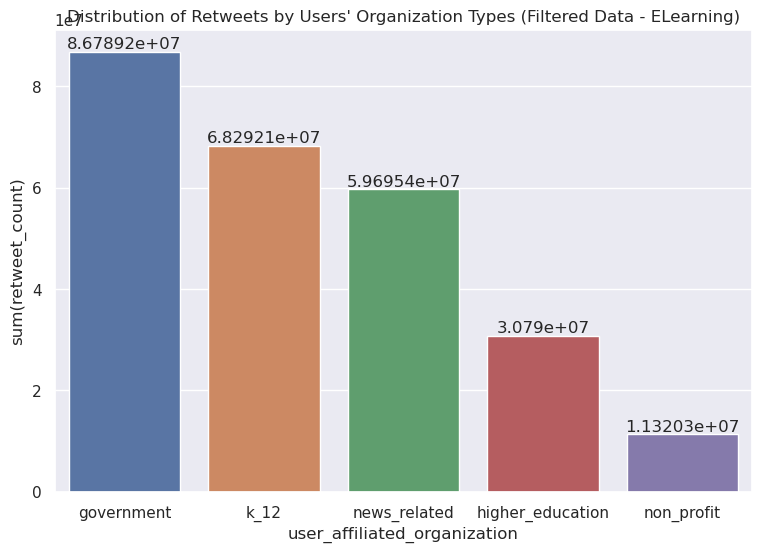

In [53]:
slice_retweet = retweet.iloc[-5:, :]

sns.set(rc={'figure.figsize':(9,6)})
ax = sns.barplot(x = slice_retweet.iloc[:,0], y = slice_retweet.iloc[:,1])
for i in ax.containers:
    ax.bar_label(i,)
    
ax.set(title="Distribution of Retweets by Users' Organization Types (Filtered Data - ELearning)")

[Text(0.5, 1.0, "Distribution of Retweets by Users' Organization Types (Filtered Data - ELearning)")]

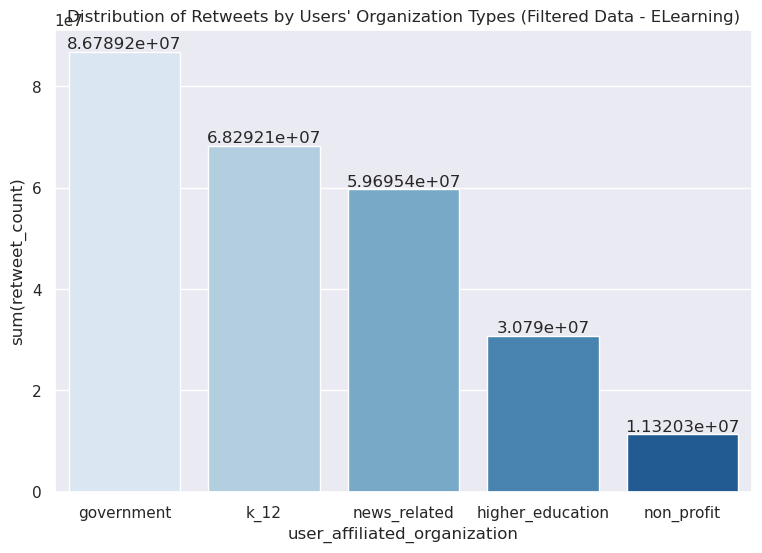

In [55]:
slice_retweet = retweet.iloc[-5:, :]

sns.set(rc={'figure.figsize':(9,6)})
colors = sns.color_palette('Blues', len(slice_retweet))
ax = sns.barplot(x=slice_retweet.iloc[:,0], y=slice_retweet.iloc[:,1], palette=colors)
for i in ax.containers:
    ax.bar_label(i)

ax.set(title="Distribution of Retweets by Users' Organization Types (Filtered Data - ELearning)")

In [57]:
location_user = elearning_df.groupby('user_location_specific').count().sort(desc(count("user_location_specific"))).limit(20).toPandas()
location_tweet = elearning_df.groupby('tweet_location_specific').count().sort(desc(count("tweet_location_specific"))).limit(20).toPandas()

In [58]:
location = pd.concat([location_user, location_tweet],axis=1)
location

,user_location_specific,count,tweet_location_specific,count
0,United States,71155,Riyadh,1297
1,London,52415,Providence,869
2,Lagos,47249,Oakland,687
3,India,37081,New Delhi,674
4,Nigeria,35635,Florida,663
5,New York,33573,Punganuru,552
6,Washington,30591,Michigan,542
7,USA,27494,Texas,467
8,Texas,26216,Houston,448
9,California,25919,Los Angeles,388


In [62]:
#usa
print(71155+33573+30591+27494+26216+25919+23739+20804+19552)

#uk
print(52415+21842+18568)

# Nigeria
print(47249+35635)
    
#India
print(37081+24705)

# canada
print(23114+19380)

# kenya
print(22049)

279043
92825
82884
61786
42494
22049


In [79]:
279043/(location.iloc[:,1].sum())

0.46314344611932323

In [59]:
to_remove = ['United States', 'India', 'Nigeria', 'USA', 'United Kingdom', 'Canada', 'UK']

location_copy = location.copy()

for place in to_remove:
    location_copy = location_copy[location_copy['user_location_specific'] != place]

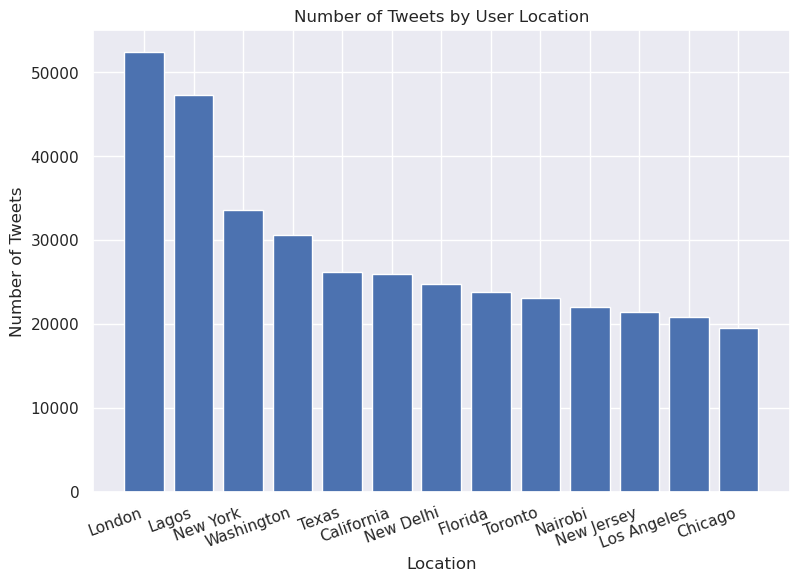

In [75]:
x = location_copy['user_location_specific']
y = location_copy.iloc[:, 1]

plt.bar(x,y)
plt.ylabel('Number of Tweets')
plt.xlabel('Location')
plt.title('Number of Tweets by User Location')
plt.xticks(rotation=20, ha='right')
plt.show()

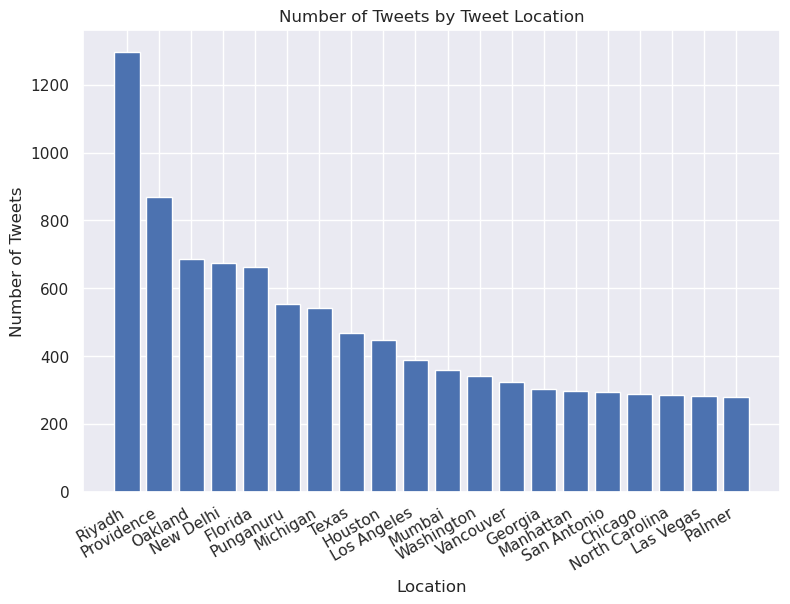

In [61]:
x = location['tweet_location_specific']
y = location.iloc[:, 3]

plt.bar(x,y)
plt.ylabel('Number of Tweets')
plt.xlabel('Location')
plt.title('Number of Tweets by Tweet Location')
plt.xticks(rotation=30, ha='right')
plt.show()

In [66]:
import pandas as pd

country_data = {
    'country_name': ['United States', 'India', 'Nigeria', 'United Kingdom', 'Canada'],
    'count': [279043, 61786, 82884, 92825, 42494]
}

user_location_country = pd.DataFrame(country_data)
user_location_country = user_location_country.sort_values(by='count', ascending=False)

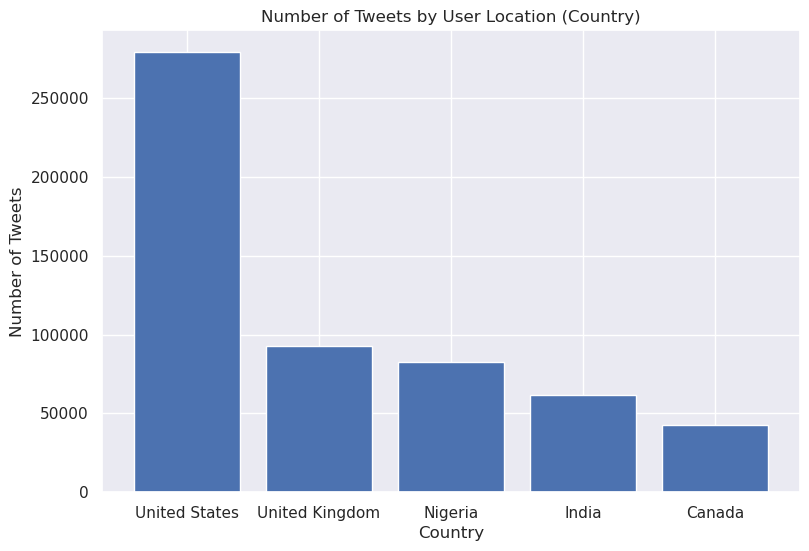

In [72]:
x = user_location_country['country_name']
y = user_location_country.iloc[:, 1]

plt.bar(x,y)
plt.ylabel('Number of Tweets')
plt.xlabel('Country')
plt.title("Number of Tweets by User Location (Country)")
plt.xticks(rotation=0, ha='center')
plt.show()

In [80]:
elearning_df.agg(countDistinct('year'))

count(year)
2


In [81]:
elearning_df.agg(countDistinct('month_year'))

count(month_year)
11
